In [319]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [302]:
src_path = '../data/'
file_types = ('.csv')
 
file_paths = []  
for root, dirs, files in os.walk(src_path):
    file_paths.extend([os.path.join(root, f) for f in files if f.endswith(file_types)])
    
print 'number of files is', len(file_paths)

number of files is 5


In [303]:
file_paths

['../data/LS-L2-biomarkers.csv',
 '../data/LS-L3-biomarkers.csv',
 '../data/LS-L4-biomarkers.csv',
 '../data/LS-L5-biomarkers.csv',
 '../data/LS-L6-biomarkers.csv']

In [331]:
biomarkers = ["Stool.Lysozyme",
              "Stool.Lactoferrin", 
              "Stool.SIgA",
              "X..SCFA.Acetate",
              "X..SCFA.Propionate",
              "X..SCFA.Valerate",
              "X..SCFA.Butyrate",
              "Total.SCFA",
              "Butyrate",
              "Stool.pH"]


#biomarker = biomarkers[1]
biomarker = "Neutrophil.Count"

In [332]:
RF_mean_scores = []
RF_std_scores = []
KNN_mean_scores = []
KNN_std_scores = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    fields = list(df.columns)
    microbiome_indx = [i for i, field in enumerate(fields) if "__" in field]

    column_names = list(df.columns)
    target_indx = [i for i, column_name in enumerate(column_names) if column_name == biomarker]
    df.iloc[:,target_indx + microbiome_indx].head()
    df_rel = df.iloc[:,target_indx + range(microbiome_indx[0], df.shape[1])]

    df_rel[[biomarker]] = df_rel[[biomarker]].apply(lambda x: pd.to_numeric(x, errors = "coerce"))
    df_clean = df_rel.dropna()
    y = np.array(df_clean[biomarker])
    X = np.array(df_clean.iloc[:,1:])

    X_train = X[:int(.8*X.shape[0]),:] # use FIRST 80% of data as training set to test on 'future'
    y_train = y[:int(.8*X.shape[0])]
    X_test = X[int(.8*X.shape[0])+1:,:]
    y_test = y[int(.8*X.shape[0])+1:]


    RF = RandomForestRegressor(n_estimators=1000)
    scores = -1*cross_validation.cross_val_score(RF, X, y, cv=10, scoring = 'mean_absolute_error')
    RF_mean_scores.append(np.mean(scores))
    RF_std_scores.append(np.std(scores))
    
    #KNN =  KNeighborsRegressor(n_neighbors=5)
    KNN = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=dict(n_neighbors=range(1,11)), n_jobs = -1, scoring = 'mean_absolute_error')
    scores = -1*cross_validation.cross_val_score(KNN, X, y, cv=10, scoring = 'mean_absolute_error')
    KNN_mean_scores.append(np.mean(scores))
    KNN_std_scores.append(np.std(scores))    
    
print "average y is:", np.mean(y)
print "std y is:", np.std(y)

average y is: 3.07
std y is: 0.754387168502


([<matplotlib.axis.XTick at 0x12d5646d0>,
 <a list of 5 Text xticklabel objects>)

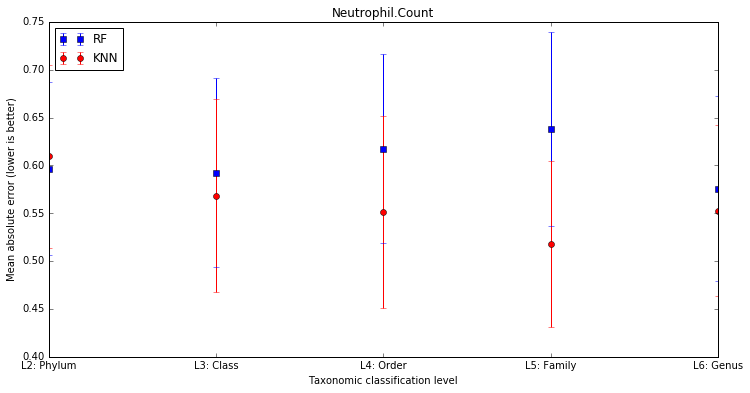

In [333]:
width = 12
height = 6
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)
ax.set_title(biomarker)
ax.set_xlabel('Taxonomic classification level')
ax.set_ylabel('Mean absolute error (lower is better)')

plt.errorbar(range(5), RF_mean_scores, yerr=np.array(RF_std_scores)/5., marker='s', c = "b", label = "RF", fmt='o')
plt.errorbar(range(5), KNN_mean_scores, yerr=np.array(KNN_std_scores)/5., marker='o', c = "r", label = "KNN", fmt='o')
plt.legend(loc='upper left')
plt.xticks(range(5), ['L2: Phylum', 'L3: Class', 'L4: Order', 'L5: Family', 'L6: Genus'])

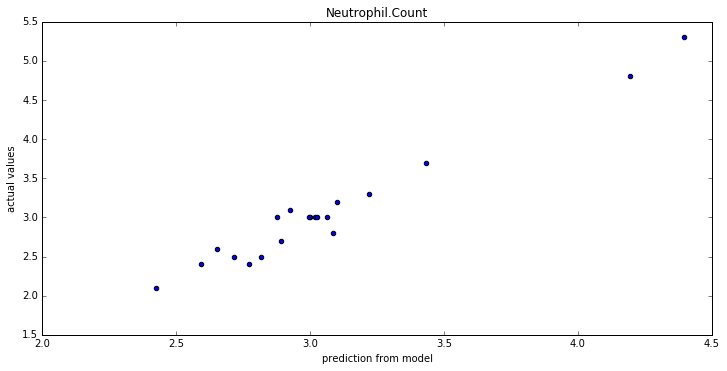

In [335]:
RF.fit(X_train, y_train)
y_pred = RF.predict(X)



width = 12
height = 6


fig = plt.figure(figsize=(width, height))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title(biomarker)

ax.set_xlabel('prediction from model')
ax.set_ylabel('actual values')
plt.scatter(y_pred, y)


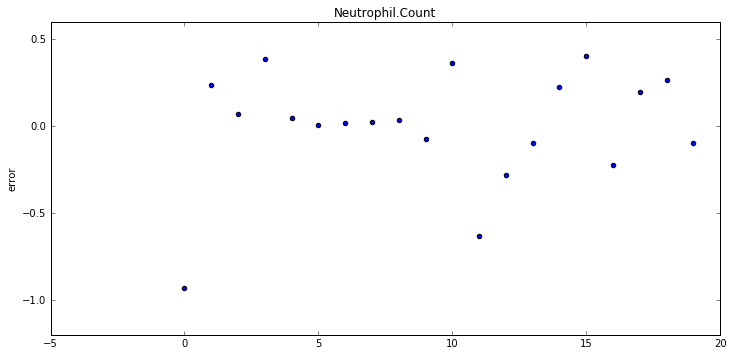

In [338]:
RF.fit(X_train, y_train)
y_pred = RF.predict(X)



width = 12
height = 6


fig = plt.figure(figsize=(width, height))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title(biomarker)

#ax.set_xlabel('prediction from model')
ax.set_ylabel('error')
plt.scatter(range(len(y_pred)), y_pred - y)



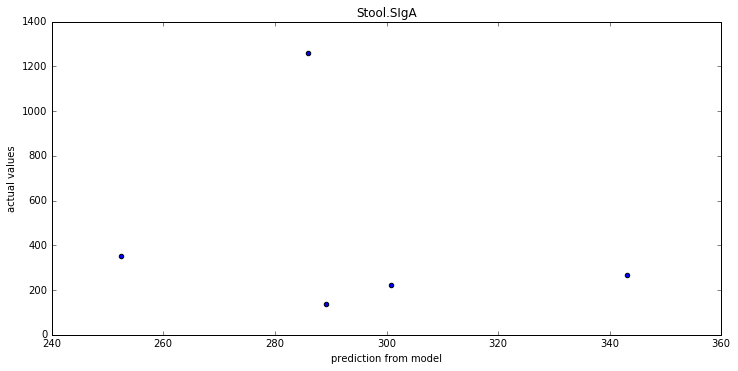

In [296]:
y_pred = RF.predict(X_test)


width = 12
height = 6


fig = plt.figure(figsize=(width, height))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title(biomarker)

ax.set_xlabel('prediction from model')
ax.set_ylabel('actual values')
plt.scatter(y_pred, y_test)

In [297]:
biomarkers

['Stool.Lysozyme',
 'Stool.Lactoferrin',
 'Stool.SIgA',
 'X..SCFA.Acetate',
 'X..SCFA.Propionate',
 'X..SCFA.Valerate',
 'X..SCFA.Butyrate',
 'Total.SCFA',
 'Butyrate',
 'Stool.pH']

In [298]:
X.shape

(30, 187)

In [300]:
df.columns

Index([u'microbiome.date', u'Date.collected', u'X',
       u'LDL..Low.Density.Lipoprotein...bad.',
       u'HDL..High.Density.Lipoprotein...good.', u'Total.Cholesterol',
       u'Triglycerides', u'TG.HDL', u'Chol.HDL',
       u'High.Sensitivity.CRP..mg.L.',
       ...
       u'g__Pseudomonas', u'g__.47', u'g__Pseudoxanthomonas',
       u'g__Stenotrophomonas', u'g__Pyramidobacter', u'g__Synergistes',
       u'g__.48', u'g__.49', u'g__.50', u'g__Akkermansia'],
      dtype='object', length=250)